In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Brief description of the problem and data (5 pts)**

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

We are tasked with creating a binary image classification model for detect metastatic cancer in small patches taken from large digital lymph node scans. The central goal is to predict whether a patch contains at least one pixel containing cancer tissue.

We will load and display the labels to start off.

In [4]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


Display first few rows.

In [9]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Check data structure.

In [11]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Display basic statistics.

In [12]:
labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Sum up null values.

In [13]:
labels.isnull().sum()

id       0
label    0
dtype: int64

Next we will check for duplicates.

In [15]:
n_duplicates = labels['id'].duplicated().sum()
print(f"\nNumber of duplicate IDs: {n_duplicates}")


Number of duplicate IDs: 0


We will clean the image data by combing through each the dataset and removing invalid image files.

In [21]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
valid_ids = []
for idx, row in labels.head(1000).iterrows():
    img_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', f"{row['id']}.tif")
    if os.path.exists(img_path):
        img = plt.imread(img_path)
        if img.shape == (96, 96, 3):
            valid_ids.append(row['id'])
clean_labels = labels[labels['id'].isin(valid_ids)].copy()
images = [plt.imread(os.path.join('/kaggle/input/histopathologic-cancer-detection/train', f"{row['id']}.tif")) 
     for _, row in clean_labels.iterrows()]
clean_labels = clean_labels['label'].values
clean_images = np.array(images)

We will display some of the images.

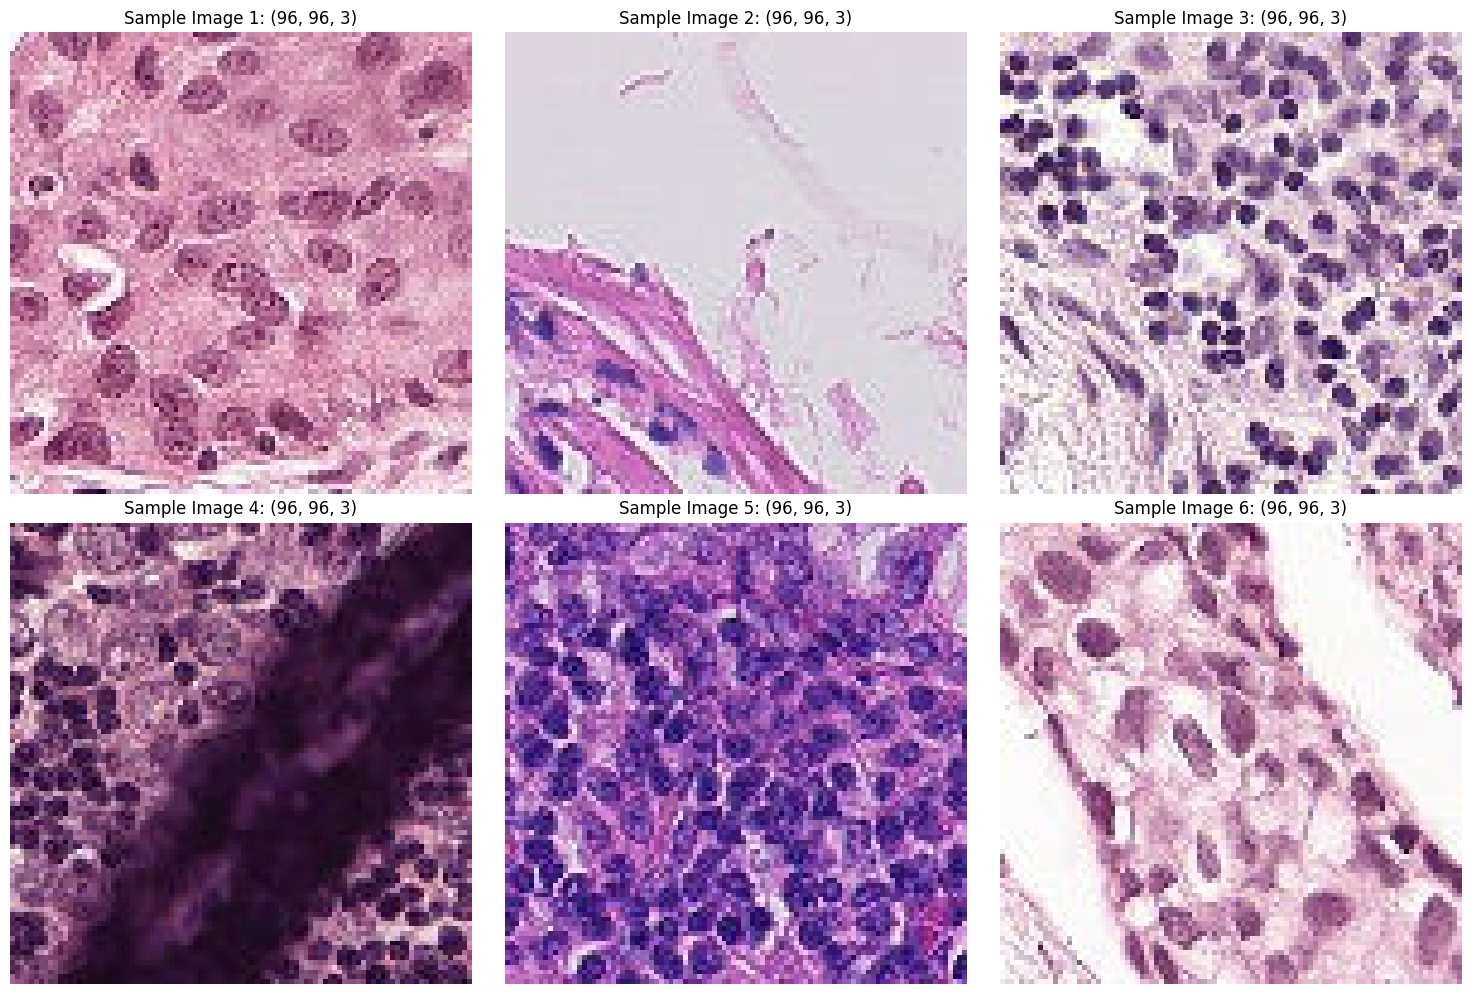

In [20]:
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = plt.imread(os.path.join('/kaggle/input/histopathologic-cancer-detection/train', 
                                os.listdir('/kaggle/input/histopathologic-cancer-detection/train')[i]))
    plt.imshow(img)
    plt.title(f'Sample Image {i+1}: {img.shape}')
    plt.axis('off')
plt.tight_layout()
plt.show()

**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

We start with a distribution of labels histogram that shows if an image has a tumor or not.

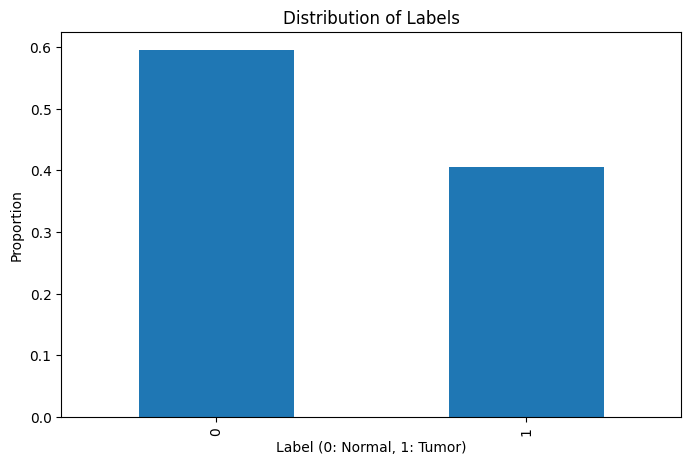

In [22]:
plt.figure(figsize=(8, 5))
labels['label'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Normal, 1: Tumor)')
plt.ylabel('Proportion')
plt.show()

Let's plot the pixel intensity.

Text(0, 0.5, 'Frequency')

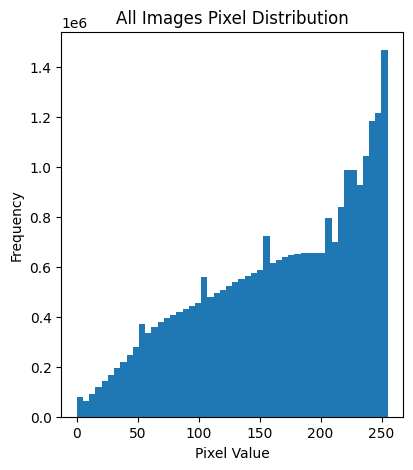

In [19]:
n_samples = 1000
subset_labels = labels.head(n_samples)
X = []
y = []
for idx, row in subset_labels.iterrows():
    img_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', f"{row['id']}.tif")
    img = plt.imread(img_path)
    X.append(img)
    y.append(row['label'])
X = np.array(X)
y = np.array(y)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
plt.hist(X.ravel(), bins=50)
plt.title('All Images Pixel Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

Based on our observations it seems the dataset is fairly balanced between images that contain cancer cells and ones that don't. The images look quite clear so there is most likely no issue in regards to resolution. 

**DModel Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

We will begin by using keras and implementing a simple CNN model which should be useful for quick and simple prototyping just to start off. We will use 3 convolutional blocks to do feature extraction to start off. 

In [23]:
def create_baseline_cnn():
    inputs = layers.Input(shape=(96, 96, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model
model = create_baseline_cnn()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 20, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,694,849 (6.47 MB)

 Trainable params: 1,694,849 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

Next we will try using a more complex ResNet model. It should be able to handle potential vanishing gradients, however it has longer training time.

In [27]:
def create_resnet_like():
    inputs = layers.Input(shape=(96, 96, 3))
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    for filters in [64, 128, 256]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

model_res = create_resnet_like()
model_res.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 48, 48, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 24, 24, 256)         │           1,0

 Total params: 1,259,905 (4.81 MB)

 Trainable params: 1,257,985 (4.80 MB)

 Non-trainable params: 1,920 (7.50 KB)

Now that the models are created we will split the data into a training and validation set to be able to detect overfitting. We will also compile the model and train it. Afterwards we will create 2 plots that contain information about the model's accuracy and loss rate for both the training and validation sets.

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.4988 - loss: 82.1159 - val_accuracy: 0.6000 - val_loss: 0.6717
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.5914 - loss: 0.7471 - val_accuracy: 0.5950 - val_loss: 0.6421
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.5893 - loss: 0.6174 - val_accuracy: 0.6050 - val_loss: 0.6467
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.6754 - loss: 0.6130 - val_accuracy: 0.5700 - val_loss: 0.7029
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.5792 - loss: 0.7052 - val_accuracy: 0.6000 - val_loss: 0.6911
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.5511 - loss: 0.7738 - val_accuracy: 0.6100 - val_loss: 0.6877
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.5831 - loss: 0.6897 - val_accuracy: 0.6050 - val_loss: 0.6839
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.5756 - loss: 0.6863 - val_accuracy: 0

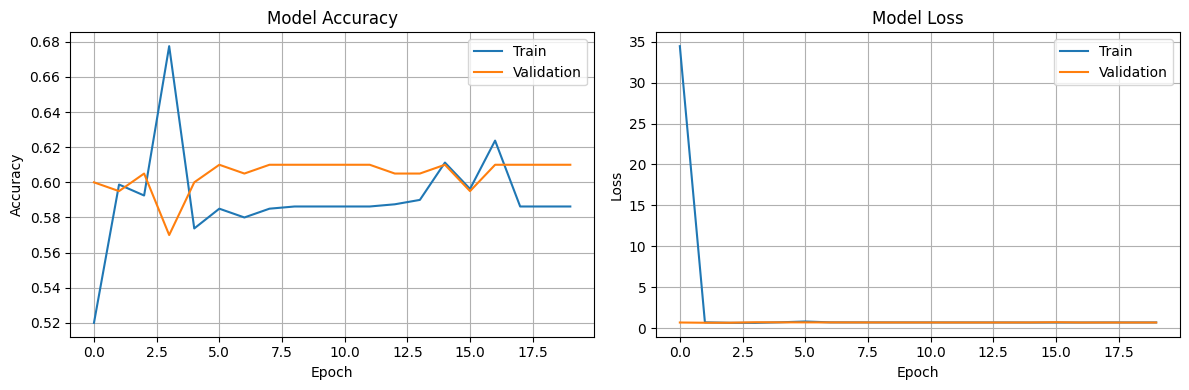

Final Training Accuracy: 0.5863
Final Validation Accuracy: 0.6100
Final Training Loss: 0.6783
Final Validation Loss: 0.6705


In [24]:
X_train, X_val, y_train, y_val = train_test_split(clean_images, clean_labels, test_size=0.2, random_state=42)
model = create_baseline_cnn()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=20,
                   batch_size=32)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

This seems to be quite a bad result since the accuracy is only slighly better than guessing and the loss rate is quite high and doesn't seem to improve, it is also quite unstable. We will try to improve the model by lowering the learning rate, reducing capacity and adding regularization, we will also pre-process the image data to normalize it.

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.5868 - loss: 0.6781 - val_accuracy: 0.6100 - val_loss: 0.6705
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.5834 - loss: 0.6792 - val_accuracy: 0.6100 - val_loss: 0.6704
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.5688 - loss: 0.6839 - val_accuracy: 0.6100 - val_loss: 0.6700
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.5844 - loss: 0.6774 - val_accuracy: 0.6100 - val_loss: 0.6644
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step - accuracy: 0.5853 - loss: 0.6680 - val_accuracy: 0.6800 - val_loss: 0.6532
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.6518 - loss: 0.6550 - val_accuracy: 0.6750 - val_loss: 0.6428
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.6734 - loss: 0.6413 - val_accuracy: 0.7050 - val_loss: 0.6305
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.7209 - loss: 0.6266 - val_accuracy: 0.

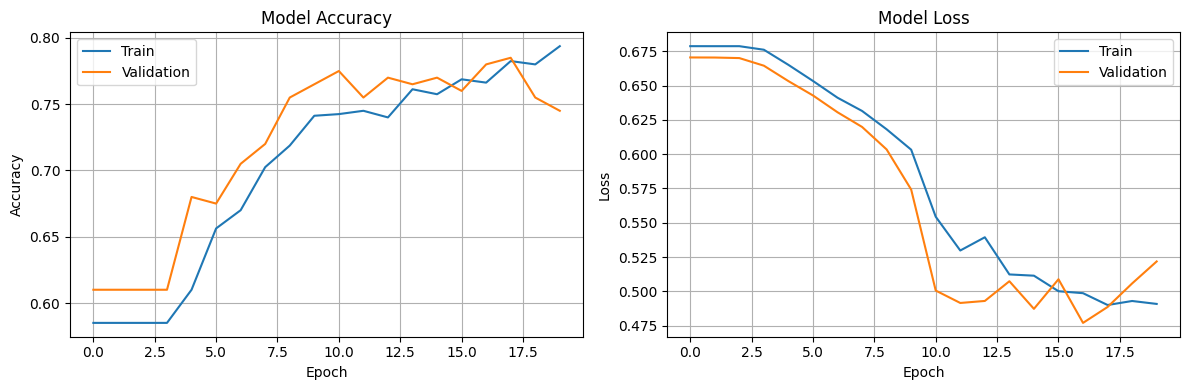

Final Training Accuracy: 0.7937
Final Validation Accuracy: 0.7450
Final Training Loss: 0.4909
Final Validation Loss: 0.5218


In [25]:
X_train, X_val, y_train, y_val = train_test_split(clean_images, clean_labels, test_size=0.2, random_state=42)
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

def create_balanced_cnn():
    inputs = layers.Input(shape=(96, 96, 3))
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])
history = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=20,
                   batch_size=32,)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

These changes seem to produce better accuracy and loss results for the data! Next, we will attempt using ResNet to see if it can produce even better results.

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7051 - loss: 0.5824 - val_accuracy: 0.6100 - val_loss: 0.6782
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7623 - loss: 0.5455 - val_accuracy: 0.6050 - val_loss: 0.6738
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7630 - loss: 0.4908 - val_accuracy: 0.5200 - val_loss: 0.7044
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7844 - loss: 0.4708 - val_accuracy: 0.5300 - val_loss: 0.7832
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7816 - loss: 0.4711 - val_accuracy: 0.5300 - val_loss: 0.8947
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7968 - loss: 0.4524 - val_accuracy: 0.5200 - val_loss: 1.2817
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8032 - loss: 0.4556 - val_accuracy: 0.4800 - val_loss: 1.6029
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8090 - loss: 0.4280 - val_accuracy: 0.4150 - val_loss:

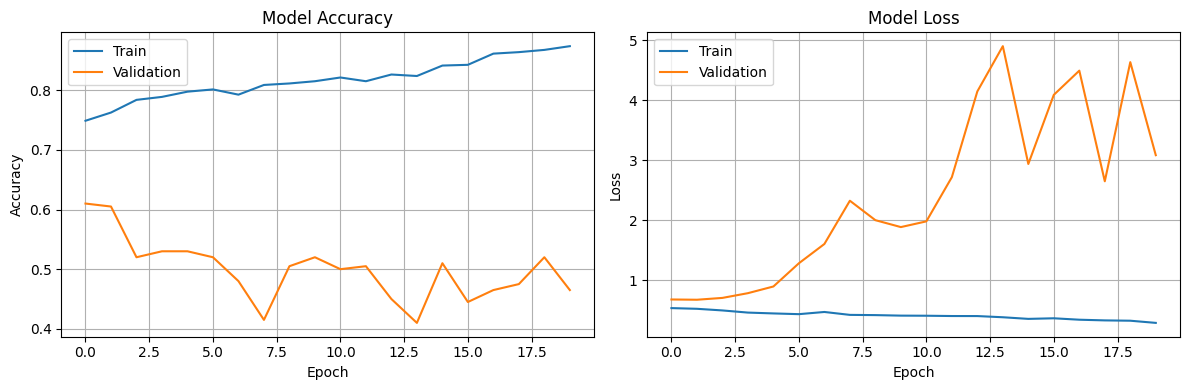

Final Training Accuracy: 0.8737
Final Validation Accuracy: 0.4650
Final Training Loss: 0.2881
Final Validation Loss: 3.0825


In [28]:
X_train, X_val, y_train, y_val = train_test_split(clean_images, clean_labels, test_size=0.2, random_state=42)
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model = create_resnet_like()
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])
history = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=20,
                   batch_size=32,)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

The result seem worse than just using CNN, there is clear overfitting as you can see the validation accuracy be quite low and it has very high loss. Most likely ResNet is too complicated for our rather simplistic dataset. It could perhaps be improved with more parameter tweaking but it seems CNN is the better model choice for this dataset. Time to submit to Kaggle!

In [5]:
def create_balanced_cnn():
    inputs = layers.Input(shape=(96, 96, 3))
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

test_files = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')
test_images = []
for img_id in test_files:
    img_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/test', img_id)
    img = plt.imread(img_path)
    test_images.append(img)
X_test = np.array(test_images).astype('float32') / 255.0
model = create_balanced_cnn()
predictions = model.predict(X_test)
submission_df = pd.DataFrame({
    'id': [img_id.split('.')[0] for img_id in test_files],
    'label': (predictions > 0.5).astype(int).flatten()
})
submission_df.to_csv('submission.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step
